<a href="https://colab.research.google.com/github/mustafasherbini/data-exploration-and-modeling/blob/main/sales_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Details

![](https://i.imgur.com/WlgNuFs.png)

In [1]:
import numpy as np              # linear algebra
import pandas as pd             # data processing, dataset file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split 
import seaborn as sns           # to visualize random distributions
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer







In [2]:
!gdown --id 1xFDvCOLa_gu34CosX8kSCIqqhD-E2te8

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xFDvCOLa_gu34CosX8kSCIqqhD-E2te8
To: /content/sales_prediction.csv
100% 870k/870k [00:00<00:00, 120MB/s]


**Data Preprocessing and Exploratory Data Analysis**

In [3]:
df = pd.read_csv("sales_prediction.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
# add new coulmn for item category 
# from first two chars at tem_Identifier	 FD : food , DR : Drink , NC : Non Consumables
df['Item_category'] = df['Item_Identifier'].str[:2]

df['Item_category']=df['Item_category'].replace({
                                              'FD' : 'Food', 
                                              'DR' : 'Drink',
                                              'NC' : 'Non_Consumables',
                                   })
df['Item_category'].value_counts()



Food               6125
Non_Consumables    1599
Drink               799
Name: Item_category, dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()   
#have null in Item_Weight : problem A
#have null in Outlet_Size  : problem B


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_category                   0
dtype: int64

In [8]:
#solve problem A

ITEM_ID_WEIGHT_PIVOT = df.pivot_table(values='Item_Weight', index='Item_Identifier').reset_index()
ITEM_ID_WEIGHT_MAPPING = dict(zip(ITEM_ID_WEIGHT_PIVOT['Item_Identifier'],ITEM_ID_WEIGHT_PIVOT['Item_Weight']))
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Identifier'].map(ITEM_ID_WEIGHT_MAPPING))
df.isnull().sum()   




Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_category                   0
dtype: int64

In [9]:
#sovle problem A
df = df.dropna(subset=['Item_Weight'])
df.isnull().sum()   
# problem A is solved


Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_category                   0
dtype: int64

In [10]:
df.groupby(by=['Outlet_Type', 'Outlet_Size']).size()



Outlet_Type        Outlet_Size
Grocery Store      Small           527
Supermarket Type1  High            932
                   Medium          930
                   Small          1860
Supermarket Type2  Medium          928
Supermarket Type3  Medium          932
dtype: int64

In [11]:
#solve problem B
outsize = {'Grocery Store': 'Small', 'Supermarket Type1': 'Small', 'Supermarket Type2': 'Medium', 'Supermarket Type3' : 'Medium'} #take the most frequncy of each type
df['Outlet_Size'] = df['Outlet_Size'].fillna(df['Outlet_Type'].map(outsize))
df.isnull().sum()   


<ipython-input-11-78a750da2d9e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlet_Size'] = df['Outlet_Size'].fillna(df['Outlet_Type'].map(outsize))


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_category                0
dtype: int64

In [12]:
df['Item_Fat_Content'].value_counts()
 #have duplicated Fat_Content type with the same meaning : problem C
# No type for Non Edible products : problem D


Low Fat    5088
Regular    2886
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [13]:
# solve problem C
df['Item_Fat_Content']=df['Item_Fat_Content'].replace({
                                              'Low Fat' : 'Low_Fat', 
                                              'LF' : 'Low_Fat',
                                              'reg' : 'Regular',
                                              'low fat' : 'Low_Fat' 
                                   })
df['Item_Fat_Content'].value_counts() #problem c is solved

<ipython-input-13-e3171e968f35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item_Fat_Content']=df['Item_Fat_Content'].replace({


Low_Fat    5516
Regular    3003
Name: Item_Fat_Content, dtype: int64

In [14]:
# solve problem D
df.loc[df['Item_category']== 'Non_Consumables','Item_Fat_Content'] ='Non_Edible'
df['Item_Fat_Content'].value_counts() #problem D is solved

Low_Fat       3917
Regular       3003
Non_Edible    1599
Name: Item_Fat_Content, dtype: int64

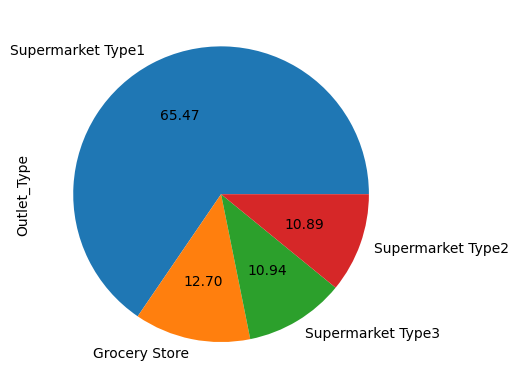

In [15]:
#  supermarket type 1 is the most frequancy in our data
df['Outlet_Type'].value_counts().plot(kind="pie", autopct="%.2f")
plt.show()



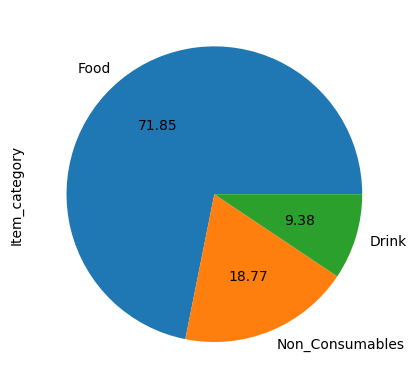

In [16]:
#  food is the most frequancy in our data

df['Item_category'].value_counts().plot(kind="pie", autopct="%.2f")
plt.show()


In [17]:
# handel categorical 





  
# Select only the numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns




#  lable encoding
le = LabelEncoder()
obj_cols = df.select_dtypes(include=['object'])



for i in obj_cols:
  df[i]=le.fit_transform(df[i])

df=(df-df.mean())/df.std()   #rescaling for all data


# Winsorize the numerical columns
df[num_cols] = df[num_cols].apply(lambda x: winsorize(x, limits=[0.05, 0.05]))






Modling



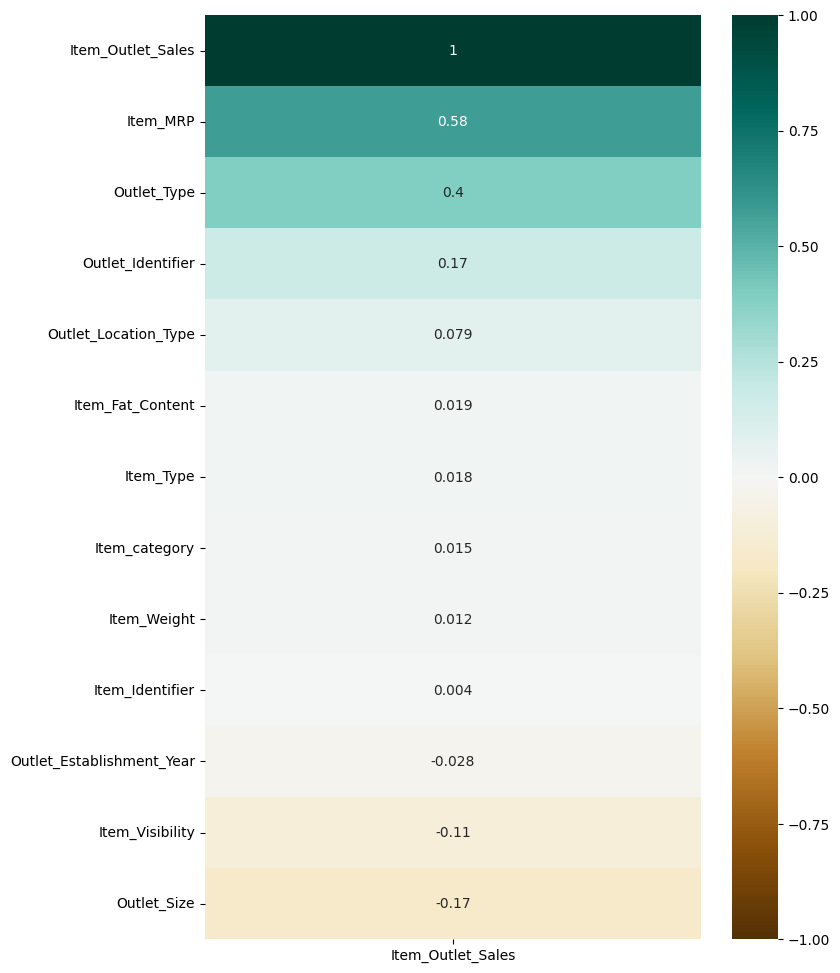

In [18]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Item_Outlet_Sales']].sort_values(by='Item_Outlet_Sales', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# from heatmap correlation there are alot of feature we are going to drip

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   float64
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   float64
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   float64
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   float64
 7   Outlet_Establishment_Year  8519 non-null   float64
 8   Outlet_Size                8519 non-null   float64
 9   Outlet_Location_Type       8519 non-null   float64
 10  Outlet_Type                8519 non-null   float64
 11  Item_Outlet_Sales          8519 non-null   float64
 12  Item_category              8519 non-null   float64
dtypes: float64(13)
memory usage: 931.8 KB


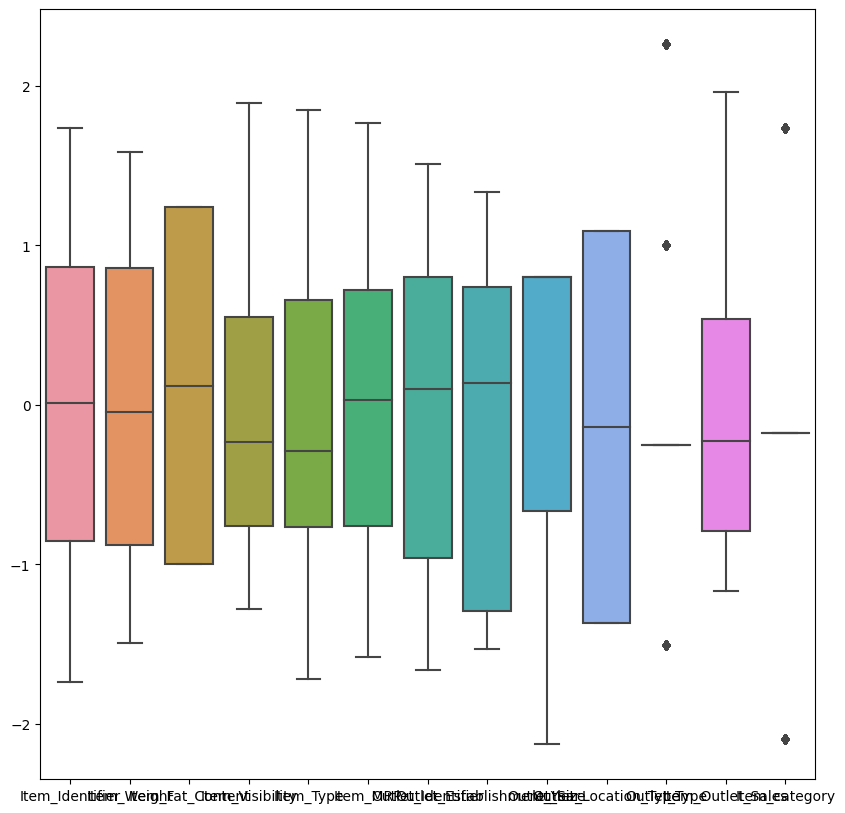

In [20]:

# Show the plot    
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)


columns_to_keep = ['Item_MRP','Item_Outlet_Sales','Outlet_Type','Outlet_Size','Item_Visibility','Outlet_Identifier']
df = df[columns_to_keep]

# df = pd.get_dummies(df, columns=['Outlet_Size','Outlet_Identifier','Outlet_Type'])

df = pd.get_dummies(df, columns=['Outlet_Type','Outlet_Size','Outlet_Identifier'])


X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']



In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X and y to arrays and reshape y
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

print(y_test.shape)

# Add a column of ones to the input data for the intercept term
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

# Initialize theta
theta = np.zeros((X_train.shape[1], 1))

# Define the cost function
def compute_cost(X, y, theta):  
  m = len(y)
  J = (1/(2*m)) * np.sum(np.square(X.dot(theta) - y))
  return J

#J(theta) = (1/2m) * Sum from i=1 to m of (h(theta)(x^(i)) - y^(i))^2

# The expression (1/(2*m)) * np.sum(np.square(X.dot(theta) - y)) is the cost function for linear regression.
# It calculates the mean squared error (MSE) between the predicted values and the actual target values.
# Here's a breakdown of the different parts of this expression:
# m is the number of training examples
# X is the input feature matrix, with dimensions (m, n) where m is the number of training examples and n is the number of features
# theta is the parameter vector, with dimensions (n, 1) where n is the number of features
# y is the target vector, with dimensions (m, 1) where m is the number of training examples
# X.dot(theta) calculates the predicted values for all training examples, with dimensions (m, 1)
# X.dot(theta) - y calculates the difference between the predicted values and the actual target values, with dimensions (m, 1)
# np.square(X.dot(theta) - y) squares each element of the difference vector, with dimensions (m, 1)
# np.sum(np.square(X.dot(theta) - y)) calculates the sum of the squared differences over all training examples
# (1/(2*m)) scales the sum by a constant factor to obtain the mean squared error (MSE)
#----------------------------------------------------------------------------------

# Gradient descent algorithm
def gradient_descent(X, y, theta, alpha, num_iters):
  m = len(y)
  J_history = np.zeros(num_iters)
  for i in range(num_iters):
    theta = theta - (alpha/m) * X.T.dot(X.dot(theta) - y)
    J_history[i] = compute_cost(X, y, theta)
  return theta, J_history

# Here's a breakdown of the different parts of this function:
# X is the input feature matrix, with dimensions (m, n+1) where m is the number of training examples and n is the number of features (not counting the intercept term)
# y is the target vector, with dimensions (m, 1) where m is the number of training examples
# theta is the parameter vector, with dimensions (n+1, 1) where n is the number of features (not counting the intercept term)
# alpha is the learning rate, which controls the step size of the parameter updates
# num_iters is the number of iterations to run the algorithm for
# m is the number of training examples
# J_history is a vector that stores the value of the cost function for each iteration
# X.T.dot(X.dot(theta) - y) calculates the gradient of the cost function with respect to the parameters theta, with dimensions (n+1, 1)
# theta - (alpha/m) * X.T.dot(X.dot(theta) - y) updates the parameters theta by taking a step in the direction of the negative gradient, with dimensions (n+1, 1)
# compute_cost(X, y, theta) calculates the value of the cost function using the updated parameters theta
# return theta, J_history returns the final parameter values and a vector containing the value of the cost function for each iteration.
# Run gradient descent
alpha = 0.01
num_iters = 1000
theta, J_history = gradient_descent(X_train, y_train, theta, alpha, num_iters)

# Make predictions on the test set
y_pred = X_test.dot(theta)

# Compute the R-squared score
r_squared = r2_score(y_test, y_pred)
print('R-squared:', r_squared)



(1704, 1)
R-squared: 0.5870521483962227


In [22]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)

y_pred = model.predict(X_test_reshaped)

r_squared = r2_score(y_test, y_pred)

print('R-squared (with RNN regression):', r_squared)

54/54 [==============================] - 0s 3ms/step
R-squared (with RNN regression): 0.6222759965755538


Data needs more preprocessing